# Project-4: Latent Factor Model
## Group 8: Suraj and Pankajdeer


In [ ]:
# import libaries
import random
import os
import numpy as np
import pandas as pd
import collections
from pathlib import Path

import time

import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.ticker as ticker

font = {'size'   : 18}    
plt.rc('font', **font)

from random import randrange
from shutil import copyfile

from sklearn.metrics import mean_squared_error


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class latentfactormodel:

  def __init__(self, num_items, num_users, num_factors, init_scale=5.0):
    # initialize the class
    self.num_factors = num_factors
    
    self.Q = np.random.rand(num_factors, num_items+1)*np.sqrt(init_scale/num_factors)
    self.P = np.random.rand(num_factors, num_users+1)*np.sqrt(init_scale/num_factors)

  def predict(self, user_id, item_id):
    # predict the rating for particular user and movie
    r = np.sum(self.Q[:,item_id] * self.P[:,user_id])
    return r
  
  def RMSE(self, y_actual, y_predicted):
    # compute the RMSE between actual and predicted rating
    rms = np.sqrt(mean_squared_error(y_actual, y_predicted))
    return round(rms,4)
    
  def error(self, ratings):
    # predict the rating for all users and movies. 
    # then compute the RMSE
    ratings_true = []
    ratings_predicted = []
    for user_id, item_id, rating_true in ratings:
      rating_predicted = self.predict(user_id, item_id)
      ratings_true.append(rating_true)
      ratings_predicted.append(rating_predicted)
    rmse = self.RMSE(ratings_true, ratings_predicted)

    return rmse
  
  def cost(self, ratings, lambda_):
    # compute the cost function 
    ratings_true = []
    ratings_predicted = []
    for user_id, item_id, rating_true in ratings:
      rating_predicted = self.predict(user_id, item_id)
      ratings_true.append(rating_true)
      ratings_predicted.append(rating_predicted)
    cost = 0
    cost += np.sum((np.array(ratings_true) - np.array(rating_predicted))**2)
    cost += lambda_*np.sum(self.P**2)
    cost += lambda_*np.sum(self.Q**2)

    return cost

  def step(self,user_id, item_id, rating_true, mu, lambda_):
    # perform one iteration of SGD for one example in the train dataset
    error_ui = (rating_true - self.predict(user_id,item_id))
    self.P[:,user_id] += mu*(error_ui*self.Q[:,item_id] - lambda_*self.P[:,user_id])
    self.Q[:,item_id] += mu*(error_ui*self.P[:,user_id] - lambda_*self.Q[:,item_id])
    
    

In [ ]:
TRAIN_RATINGS_PATH = '/content/drive/My Drive/Coursework/CS 5683_Big_Data/Project-4/training_dataset.csv'
TEST_RATINGS_PATH = '/content/drive/My Drive/Coursework/CS 5683_Big_Data/Project-4/test_dataset.csv'

# import train and test dataset
train_data = pd.read_csv(TRAIN_RATINGS_PATH,
            sep=",", engine="python",
            names=["user_id", "item_id", "rating"],
            usecols=[0, 1, 2], skiprows=1)

test_data = pd.read_csv(TEST_RATINGS_PATH,
            sep=",", engine="python",
            names=["user_id", "item_id", "rating"],
            usecols=[0, 1, 2], skiprows=1)

num_users = max(train_data.user_id.max(), test_data.user_id.max()) 
num_items = max(train_data.item_id.max(), test_data.item_id.max())
global_mean = train_data.rating.mean()
train_data, test_data = train_data.values, test_data.values



In [ ]:
# define parameters of the latent factor model
num_epochs = 40
mu = 0.01
lambda_ = 0.1
num_factors = 25

# store rmse, cost at each iteration
rmse_cost_plot = np.zeros((num_epochs,5))

# define the object for latent factor model
lf = latentfactormodel(num_items + 1, num_users + 1, num_factors)

print("{:<10} {:<15} {:<15} ".format('Iteration', 'Train RMSE', 'Test TMSE'))
epochs = 0
print("{:<10} {:<15} {:<15} ".format(epochs, lf.error(train_data), lf.error(test_data)))

rmse_cost_plot[epochs,0] = epochs 
rmse_cost_plot[epochs,1], rmse_cost_plot[epochs,2] = lf.error(train_data), lf.error(test_data)
rmse_cost_plot[epochs,3], rmse_cost_plot[epochs,4] = lf.cost(train_data,lambda_), lf.cost(test_data, lambda_)

start = time.time()
# perform SGD for fixed number of epochs
for epochs in range(num_epochs):
  for idx in np.random.permutation(train_data.shape[0]):
    # perform SGD for each example in the train data set
    lf.step(*train_data[idx], mu, lambda_,)

  # store the RMSE and cost
  rmse_cost_plot[epochs,0] = epochs
  rmse_cost_plot[epochs,1], rmse_cost_plot[epochs,2]  =  lf.error(train_data), lf.error(test_data)
  rmse_cost_plot[epochs,3], rmse_cost_plot[epochs,4] = lf.cost(train_data,lambda_), lf.cost(test_data, lambda_)

  print("{:<10} {:<15} {:<15} ".format(epochs, lf.error(train_data), lf.error(test_data)))

print('Total CPU time = ', time.time() - start)

Iteration  Train RMSE      Test TMSE       
0          2.5634          2.4796          
0          0.9782          0.9643          
1          0.9397          0.952           
2          0.9314          0.9457          
3          0.9259          0.9469          
4          0.9223          0.9427          
5          0.9198          0.9382          
6          0.917           0.943           
7          0.9125          0.9388          
8          0.9095          0.9341          
9          0.9043          0.9354          
10         0.8991          0.9316          
11         0.8923          0.9228          
12         0.8882          0.9237          
13         0.8815          0.9168          
14         0.8748          0.9123          
15         0.8708          0.9093          
16         0.8651          0.9125          
17         0.8596          0.9091          
18         0.8569          0.9117          
19         0.8502          0.9042          
20         0.8456          0.905

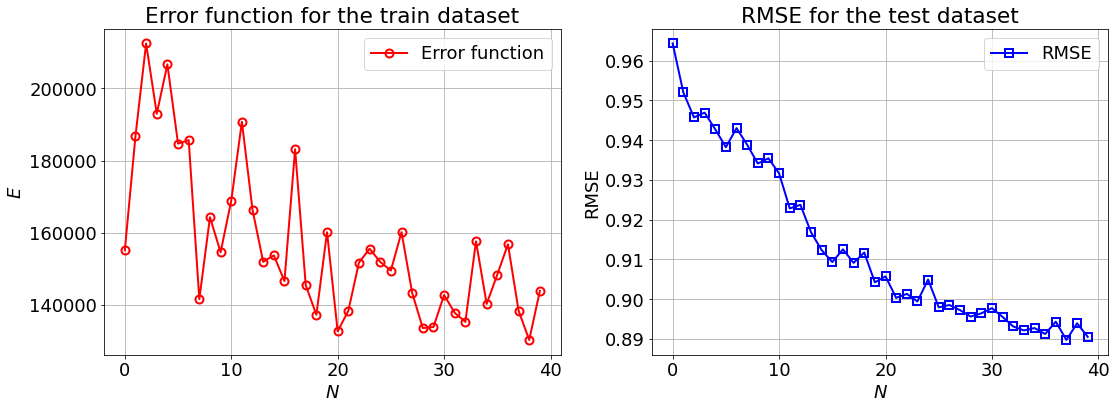

In [ ]:
# RMSE and cost plotting
fig, ax = plt.subplots(1,2,figsize=(18,6))
axs = ax.flat

axs[0].plot(rmse_cost_plot[:,0], rmse_cost_plot[:,3], 'ro-', lw=2, ms=8, mew=2, fillstyle='none',  label='Error function')
axs[1].plot(rmse_cost_plot[:,0], rmse_cost_plot[:,2], 'bs-', lw=2, ms=8, mew=2, fillstyle='none',  label='RMSE')

axs[0].grid()
axs[0].set_xlabel('$N$')
axs[0].set_ylabel('$E$')
axs[0].set_title('Error function for the train dataset')
axs[0].legend(loc=0)

axs[1].grid()
axs[1].set_xlabel('$N$')
axs[1].set_ylabel('RMSE')
axs[1].set_title('RMSE for the test dataset')
axs[1].legend(loc=0)


# plt.suptitle('Latent factor model ')

# fig.tight_layout()
plt.show()

### Comparison of RMSE on test dataset
#### 1. Collaborative filtering:
RMSE for two different measure of similarity: <br>
- Cosine similarity: 0.9393
- Adjusted cosine similarity: 0.8829

Time taken to execute:
- Cosine similarity measure: 36 seconds
- Adjusted cosine similarity measure: 35 seconds
<br>

#### 2. Latent factor model:
RMSE for set of given hperaprameters ($k=25,\lambda=0.1,\mu=0.01,N=40$): <br>
- Latent factor model: 0.8905

Time taken to execute:
- Latnet factor model: 210 seconds

<br>

**Inference:** 
- From the comparison of RMSE for collaborative filtering and latent factor model (for a given set of hyperparameters), we can see that the collaborative filtering with adjusted cosine similarairty leads to better prediciton from three models. 
- In case of the collaborative filtering, the rating of movies which are present in the test dataset and not in train dataset cannot be detrmined. We assign the mean user rating for such movies and the performance was better than assigning global mean for these movies. 
- In  terms of the computational cost, latent factor model might seems disadvantageous. However, there is not need of storing the utility matrix for latent factor model, and hence is attractive for large dataset.
- The performance of the latent factor model can be furhter improved by optimizing additional paraeters like user and movie bias and also tuning of hyperparameters. For the advance model we optimize user and movie bias suing SGD. With the advance model, we predict movie rating as the sum of gloabal mean, movie bias, user bias, and the product of $P$ and $Q$. We achieve the RMSE = 0.8802 for $k=30,\lambda=0.1,\mu=0.01,N=40$. It should be noted that the RMSE value depends upon the initilization of the matrix P and Q, and the performance might be slightly different for each run. 

## Team Participation and Contribution:
- As a team we discussed the approach and logic to perform recommendation sysytem implementation using collaborative filtering and latnet factor model. 
- We discussed data structure to use for efficient and fast computation. For, example we use numpy at most of the places and avoid *for loops* which are very slow in Python

Pankajdeer:
- Implemented the logic for collaborative filtering
- Completed the program implementation and execution for collaborative filtering
- Performed RMSE computation

Suraj:
- Implemented the logic for latent factor model
- Completed the program implementation and execution for latent factor model
- Developed visulizations for plotting cost function values in each iteration

 
At the end, we brought uniformity in implementation for both approaches of recommendation system and compared the steps taken to find out any bugs or mistakes. Overall, it was a very good experience working together as a group  and exchanging ideas.